In [1]:
import json
import pandas as pd
from pandas.io.json import json_normalize
import os
from os.path import join
import unicodedata
from bs4 import BeautifulSoup

In [2]:
# Parsing the ads into a dataframe

path_to_data = "/Users/annl/Desktop/GenieProjekt/data/"
path_to_files_gu_se = path_to_data + "jobbannonser_GU/SE/"
path_to_files_gu_en = path_to_data + "jobbannonser_GU/UK/"
path_to_files_ltu_se = path_to_data + "LTU-annonser/SE/"
path_to_files_ltu_en = path_to_data + "LTU-annonser/UK/"
path_to_files_ch_se = path_to_data + "Chalmers-annonser/SE/"
path_to_files_ch_en = path_to_data + "Chalmers-annonser/UK/"

def listdir_path(directory) : 
    return [os.path.abspath(os.path.join(directory, p)) for p in os.listdir(directory)]

files_ltu_se = listdir_path(path_to_files_ltu_se)
files_ltu_en = listdir_path(path_to_files_ltu_en)
files_ch_se  = listdir_path(path_to_files_ch_se)
files_ch_en  = listdir_path(path_to_files_ch_en)
files_gu_se  = listdir_path(path_to_files_gu_se)
files_gu_en  = listdir_path(path_to_files_gu_en)

files_ltu_all = files_ltu_se + files_ltu_en
files_ch_all = files_ch_se + files_ch_en
files_gu_all = files_gu_se + files_gu_en

def create_dataframe(files) : 
    datalist = []
    for file in files :       
        if file.endswith(".json"):
           new_row = pd.read_json(file,typ="series")
           datalist.append(new_row)
    df = pd.DataFrame(data = datalist)
    for i, row in df.iterrows():
        text_val = unicodedata.normalize("NFKD", BeautifulSoup(row['text']).get_text(separator="\n"))
        df.at[i,'text'] = text_val
    return df

In [3]:
from langdetect import detect

# Finds the language of each ad
def detect_langs(df) :
    langs = []
    for x in (df['text']) : 
        try: 
            langs.append(detect(x))
        except : 
            langs.append('failed')
    return langs
 
# Picks out the ads in the specified language
def filter_lang(df,lang) : 
    langs = detect_langs(df)
    df_lang = df
    df_lang['lang'] = langs
    return ((df_lang.loc[df['lang'].isin([lang])]))

In [4]:
import sys
import numpy as np

# Remove "tillkännagivanden" and duplicate ads
forbidden_strings = 'tillkänn|platsb|banken|arbet|ams| af|tkg|pb|tillsätt|beslut|eur|axess|axcess'

def remove_non_ads(df) :
    df = df[~(df['variant_name'].str.lower().str.contains(forbidden_strings,na = False))]
    df = df[~(df['prefix_text'].str.lower().str.contains(forbidden_strings,na = False))]  
    df = df.drop_duplicates(subset='text')
    df = df.reset_index(drop=True)
    return df


In [5]:
df_ltu  = remove_non_ads(create_dataframe(files_ltu_all))
df_ch   = remove_non_ads(create_dataframe(files_ch_all))
df_gu   = remove_non_ads(create_dataframe(files_gu_all))

df_ltu_en = filter_lang(df_ltu,'en').reset_index()
df_ltu_sv = filter_lang(df_ltu,'sv').reset_index()
df_ch_en  = filter_lang(df_ch,'en').reset_index()
df_ch_sv  = filter_lang(df_ch,'sv').reset_index()
df_gu_en  = filter_lang(df_gu,'en').reset_index()
df_gu_sv  = filter_lang(df_gu,'sv').reset_index()

# The ads not detected as swedish or english all seem to be tests and can be discarded
#((df.loc[~df['lang'].isin(['en','sv'])]))

In [6]:
df_ltu_en.to_csv("jobads_ltu_en.csv")
df_ch_en.to_csv("jobads_ch_en.csv")
df_gu_en.to_csv("jobads_gu_en.csv")
df_ltu_sv.to_csv("jobads_ltu_sv.csv")
df_ch_sv.to_csv("jobads_ch_sv.csv")
df_gu_sv.to_csv("jobads_gu_sv.csv")

In [7]:
sys.path.append("..")
# https://github.com/Doteveryone/genderdecoder
from genderdecoder import assess

def assess_ads(df) : 
    job_descriptions = df['text']
    job_ids = df['id']
   
    result_df = pd.DataFrame(columns=['id','result','number_of_masc_words'])
  
    for i,jd in enumerate(job_descriptions) :
        ass = assess(jd)

        result_df.at[i,'id'] = (str(job_ids[i]))
        result_df.at[i,'result'] = ass.get('result')
        result_df.at[i,'number_of_masc_words'] = len(ass.get('masculine_coded_words'))    
        result_df.at[i,'number_of_fem_words'] = len(ass.get('feminine_coded_words'))
        result_df.at[i,'year'] = df.iloc[i]['date_created']
        if len(ass.get('feminine_coded_words')) != 0 :
            result_df.at[i,'ratio'] = len(ass.get('masculine_coded_words')) / len(ass.get('feminine_coded_words'))
        else : result_df.at[i,'ratio'] = len(ass.get('masculine_coded_words')) 
    return result_df
    

In [9]:
# Split data into years

years = ["2011","2012","2013","2014","2015","2016","2017","2018","2019","2020","2021"]

def filter_on_year(df,year) :
    return df[(df['date_created'].str.startswith(year,na = False))].reset_index()

dfs_ltu = [filter_on_year(df_ltu_en,year) for year in years]
dfs_gu  = [filter_on_year(df_gu_en,year) for year in years]
dfs_ch  = [filter_on_year(df_ch_en,year) for year in years]



In [10]:
assess_ltu = [assess_ads(df) for df in dfs_ltu]
assess_gu  = [assess_ads(df) for df in dfs_gu]
assess_ch  = [assess_ads(df) for df in dfs_ch]

def assess_values(df) :
    return  [ ((df[i]['result']).value_counts().to_frame().T) for i in range(len(df))]

assess_values_ltu = assess_values(assess_ltu) 
assess_values_gu  = assess_values(assess_gu) 
assess_values_ch  = assess_values(assess_ch)


In [11]:
import matplotlib.pyplot as plt

def plot_count_by_year(df,title) : 

    # Numbers of pairs of bars
    N = 11

    masc_bar = [ ass.iloc[0]['masculine-coded'] if 'masculine-coded' in ass.columns      
                else 
                    0
                for ass in df]

    fem_bar = [ ass.iloc[0]['feminine-coded'] if 'feminine-coded' in ass.columns      
                else 
                    0
                for ass in df]

    very_masc_bar = [ ass.iloc[0]['strongly masculine-coded'] if 'strongly masculine-coded' in ass.columns      
                else 
                    0
                for ass in df]

    very_fem_bar = [ ass.iloc[0]['strongly feminine-coded'] if 'strongly feminine-coded' in ass.columns      
                else 
                    0
                for ass in df]

    neut_bar = [ ass.iloc[0]['neutral'] if 'neutral' in ass.columns      
                else 
                    0
                for ass in df]

    # Position of bars on x-axis
    ind = np.arange(N*2,step = 2)

    # Figure size
    plt.figure(figsize=(10,5))

    # Width of a bar 
    width = 0.3       

    plt.bar(ind, masc_bar , width, label='masculine encoded ads',color='skyblue')
    plt.bar(ind + width, fem_bar, width, label='feminine encoded ads',color='pink')
    plt.bar(ind + 2*width, neut_bar, width, label='neutral ads',color='mediumpurple')
    plt.bar(ind + 3*width, very_masc_bar, width, label='strongly masculine encoded ads',color='blue')
    plt.bar(ind + 4*width, very_fem_bar, width, label='strongly feminine encoded ads',color='deeppink')

    plt.ylabel('Number of advertisements')
    plt.title('Ratios of masculine and feminine encoded job advertisements from ' + title)
   
    # First argument - A list of positions at which ticks should be placed
    # Second argument -  A list of labels to place at the given locations
    plt.xticks(ind + width, ('2011', '2012', '2013','2014', '2015', '2016','2017', '2018', '2019','2020','2021'))

# Finding the best position for legends and putting it
    plt.legend(loc='best')
    plt.show()


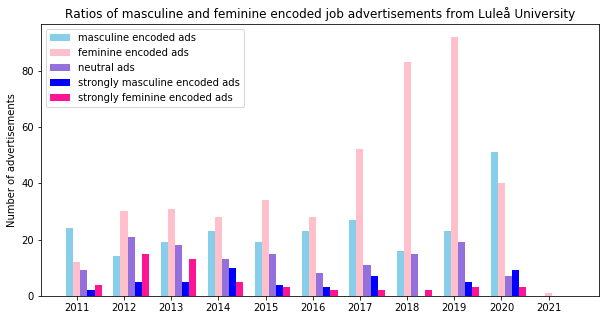

In [12]:
plot_count_by_year(assess_values_ltu,"Luleå University")

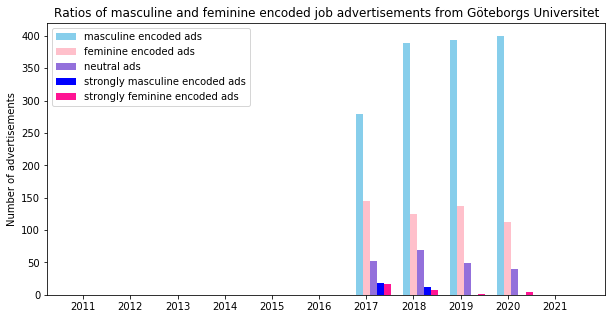

In [13]:
plot_count_by_year(assess_values_gu,"Göteborgs Universitet")

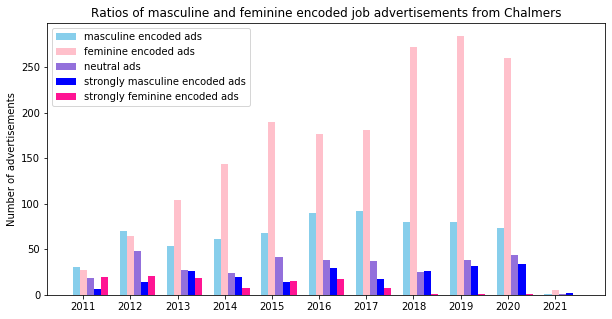

In [14]:
plot_count_by_year(assess_values_ch,"Chalmers")